<a href="https://colab.research.google.com/github/leonardoub/SCRIPT_PALERMO/blob/master/Hyperparameter_optimization_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Optimization of hyperparameter

In [1]:
!pip install -U keras-tuner

     |████████████████████████████████| 92kB 2.4MB/s 
     |████████████████████████████████| 421.8MB 37kB/s 
     |████████████████████████████████| 450kB 47.2MB/s 
     |████████████████████████████████| 3.8MB 53.5MB/s 
     |████████████████████████████████| 81kB 9.8MB/s 
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15354 sha256=2270dc56b756053b7856bd11645c9a63cc8b7517cec52d03a177822678cc7b1d
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built terminaltables
ERROR: tensorflow 2.1.0rc2 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.3.3 which is incompatible.
ERROR: tensorboard 2.1.0 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.1

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

#Load data

In [3]:
#load data from Drive
from google.colab import drive
drive.mount('/gdrive')
#%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
train_dataset_path = '/gdrive/My Drive/AIM_PA/database_training2.csv'
test_dataset_path = '/gdrive/My Drive/AIM_PA/database_nostro_without_nan.csv'

In [0]:
df_train = pd.read_csv(train_dataset_path)
df_test = pd.read_csv(test_dataset_path)

In [0]:
df_train.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_test.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_train.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)
df_test.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)

In [0]:
train_data = df_train.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
test_data = df_test.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
train_labels = df_train.Histology

In [0]:
test_labels = df_test.Histology

##Z score dei dati

In [0]:
mean = train_data.mean(axis=0)
train_data_stand = train_data - mean
std = train_data.std(axis=0)
train_data_stand /= std

In [0]:
test_data_stand = test_data - mean
test_data_stand /= std

##Vettorizzare i label

In [0]:
word_index={'adenocarcinoma':0, 'large cell':1, 'squamous cell carcinoma':2}

In [0]:
train_labels_dec = [word_index[label] for label in train_labels]

In [0]:
test_labels_dec = [word_index[label] for label in test_labels]

In [18]:
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [0]:
one_hot_train_labels = to_categorical(train_labels_dec)
one_hot_test_labels = to_categorical(test_labels_dec)

#PCA

In [0]:
from sklearn.decomposition import PCA

In [0]:
pca = PCA(n_components=0.9, svd_solver='full')

In [22]:
pca.fit(train_data_stand)

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

In [0]:
train_data_stand_pca = pca.transform(train_data_stand)
test_data_stand_pca = pca.transform(test_data_stand)

In [24]:
train_data_stand_pca.shape

(131, 9)

#Building Network

In [0]:
from tensorflow import keras

In [0]:
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence

In [0]:
from tensorflow.keras import layers

In [0]:
from tensorflow.keras import regularizers

In [0]:
from tensorflow.keras.optimizers import SGD

In [0]:
from kerastuner.tuners import RandomSearch

In [0]:
def build_model(hp):
  model = keras.models.Sequential()

#  model.add(layers.Dense(units=(hp.Int('units', min_value=3, max_value=8, step=1)), 
#                         activation='relu', input_shape=(9,)))

  model.add(layers.Dense(6, activation='relu', input_shape=(9,)))
  model.add(layers.Dense(3, activation='softmax'))
#  sgd = SGD(lr=0.001, decay=1e-6, momentum=0.5, nesterov=True)
  lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
  momentum = hp.Choice('momentum', [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
  model.compile(optimizer=SGD(learning_rate=lr, momentum=momentum), 
                loss='categorical_crossentropy', metrics=['accuracy'])
  return model

#Stratified k-fold

This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [0]:
from sklearn.model_selection import StratifiedKFold

In [33]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
skf.get_n_splits(train_data_stand_pca, train_labels_dec)

10

In [34]:
for train_index, test_index in skf.split(train_data_stand_pca, train_labels_dec):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [  0   1   2   4   5   6   7   8   9  10  11  12  14  15  16  17  18  19
  20  22  23  24  25  27  28  29  30  31  32  33  34  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  51  52  53  55  56  57  58  59  60
  61  62  63  64  65  66  67  69  70  71  72  74  75  76  77  78  79  80
  81  83  84  85  86  87  88  89  90  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 107 108 109 110 111 113 114 115 116 117 119 120 121
 122 123 124 125 126 127 128 129] TEST: [  3  13  21  26  35  50  54  68  73  82  91 106 112 118 130]
TRAIN: [  0   1   3   4   5   6   8   9  10  11  12  13  14  15  16  17  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  44  45  46  48  49  50  51  52  53  54  55  56  57  58
  59  60  62  63  64  65  66  67  68  69  71  72  73  75  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  94  95  96  97  98
 100 101 102 103 104 105 106 107 109 110 111 112 113 115 116 117 118 120
 121 122

In [35]:
train_labels_dec[125]

2

In [0]:
from keras.utils import to_categorical


In [0]:
#for train_index, val_index in skf.split(train_data_stand_pca, train_labels_dec):
 
#  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
#  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])

#  val_data = np.array([train_data_stand_pca[i] for i in val_index])
#  val_targets = np.array([train_labels_dec[i] for i in val_index])

#  one_hot_partial_train_targets = to_categorical(partial_train_targets)
#  one_hot_val_targets = to_categorical(val_targets)

#  model = build_model()
#  model.fit(partial_train_data, one_hot_partial_train_targets, epochs = num_epochs, batch_size=1)

#  val_loss, val_accuracy = model.evaluate(val_data, one_hot_val_targets)
#  all_scores.append(val_accuracy)
#I parametri per la valutazione vengono calcolati una volta per ogni k-fold, per ogni set di validazione, quindi k volte

C'è un problema: keras.utils.to_categorical produces a one-hot encoded class vector, i.e. the multilabel-indicator mentioned in the error message. StratifiedKFold is not designed to work with such input; i.e. your y must be a 1-D array of your class labels.
Essentially, what you have to do is simply to invert the order of the operations: split first (using your intial y_train), and convert to_categorical afterwards.

#Keras tuner RandomSearch

In [38]:
num_epochs = 50
#all_acc_histories = []
#all_loss_histories = []
#all_val_acc_histories = []
#all_val_loss_histories = []

for train_index, val_index in skf.split(train_data_stand_pca, train_labels_dec):
 
  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])
  
  val_data = np.array([train_data_stand_pca[i] for i in val_index])
  val_targets = np.array([train_labels_dec[i] for i in val_index])

  one_hot_partial_train_targets = to_categorical(partial_train_targets)
  one_hot_val_targets = to_categorical(val_targets)

 
  tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=10, 
                       executions_per_trial=3, directory='/content/my_dir', project_name='helloworld')
  
  tuner.search_space_summary()

  tuner.search(partial_train_data, one_hot_partial_train_targets, validation_data=(val_data, one_hot_val_targets), 
                      epochs=num_epochs, batch_size=10)
  

#  acc_history = history.history['acc']
#  all_acc_histories.append(acc_history)

#  loss_history = history.history['loss']
#  all_loss_histories.append(loss_history)

#  acc_val_history = history.history['val_acc']
#  all_val_acc_histories.append(acc_val_history)

#  loss_val_history = history.history['val_loss']
#  all_val_loss_histories.append(loss_val_history)
  

#I parametri per la valutazione vengono calcolati per ogni epoca, quindi num_epochs volte. 
#Il tutto viene ripetuto un numero di volte pari a n_splits.
#Si ottiene una lista con n_splits elementi ciascuno dei quali è una lista lunga num_epochs,
#ogni elemento può essere uno fra questi: dict_keys(['val_loss', 'val_acc', 'loss', 'acc']) 

Train on 116 samples, validate on 15 samples
Epoch 1/50
116/116 [==============================] - 0s 3ms/sample - loss: 3.1082 - accuracy: 0.3362 - val_loss: 2.6273 - val_accuracy: 0.2667
Epoch 2/50
116/116 [==============================] - 0s 448us/sample - loss: 1.9073 - accuracy: 0.3534 - val_loss: 2.0746 - val_accuracy: 0.3333
Epoch 3/50
116/116 [==============================] - 0s 301us/sample - loss: 1.3860 - accuracy: 0.3362 - val_loss: 1.7900 - val_accuracy: 0.2000
Epoch 4/50
116/116 [==============================] - 0s 349us/sample - loss: 1.1637 - accuracy: 0.5000 - val_loss: 1.6338 - val_accuracy: 0.3333
Epoch 5/50
116/116 [==============================] - 0s 284us/sample - loss: 1.0665 - accuracy: 0.5431 - val_loss: 1.6176 - val_accuracy: 0.3333
Epoch 6/50
116/116 [==============================] - 0s 327us/sample - loss: 1.0330 - accuracy: 0.5517 - val_loss: 1.5898 - val_accuracy: 0.3333
Epoch 7/50
116/116 [==============================] - 0s 260us/sample - loss: 1.0

Train on 116 samples, validate on 15 samples
Epoch 1/50
116/116 [==============================] - 0s 3ms/sample - loss: 1.2536 - accuracy: 0.4828 - val_loss: 1.3014 - val_accuracy: 0.2667
Epoch 2/50
116/116 [==============================] - 0s 373us/sample - loss: 1.1082 - accuracy: 0.5259 - val_loss: 1.2594 - val_accuracy: 0.5333
Epoch 3/50
116/116 [==============================] - 0s 293us/sample - loss: 1.0482 - accuracy: 0.5259 - val_loss: 1.2127 - val_accuracy: 0.5333
Epoch 4/50
116/116 [==============================] - 0s 270us/sample - loss: 1.0203 - accuracy: 0.5259 - val_loss: 1.2120 - val_accuracy: 0.5333
Epoch 5/50
116/116 [==============================] - 0s 262us/sample - loss: 0.9720 - accuracy: 0.5517 - val_loss: 1.1914 - val_accuracy: 0.5333
Epoch 6/50
116/116 [==============================] - 0s 338us/sample - loss: 0.9538 - accuracy: 0.5517 - val_loss: 1.1648 - val_accuracy: 0.5333
Epoch 7/50
116/116 [==============================] - 0s 356us/sample - loss: 0.9

Train on 116 samples, validate on 15 samples
Epoch 1/50
116/116 [==============================] - 0s 3ms/sample - loss: 1.9030 - accuracy: 0.3103 - val_loss: 1.9749 - val_accuracy: 0.2667
Epoch 2/50
116/116 [==============================] - 0s 355us/sample - loss: 1.7212 - accuracy: 0.2931 - val_loss: 1.8019 - val_accuracy: 0.3333
Epoch 3/50
116/116 [==============================] - 0s 266us/sample - loss: 1.5829 - accuracy: 0.3534 - val_loss: 1.6955 - val_accuracy: 0.3333
Epoch 4/50
116/116 [==============================] - 0s 305us/sample - loss: 1.4854 - accuracy: 0.3534 - val_loss: 1.6033 - val_accuracy: 0.2667
Epoch 5/50
116/116 [==============================] - 0s 310us/sample - loss: 1.4167 - accuracy: 0.3276 - val_loss: 1.5414 - val_accuracy: 0.2667
Epoch 6/50
116/116 [==============================] - 0s 308us/sample - loss: 1.3649 - accuracy: 0.3362 - val_loss: 1.4730 - val_accuracy: 0.2667
Epoch 7/50
116/116 [==============================] - 0s 313us/sample - loss: 1.3

Train on 116 samples, validate on 15 samples
Epoch 1/50
116/116 [==============================] - 0s 3ms/sample - loss: 2.2950 - accuracy: 0.4310 - val_loss: 2.3061 - val_accuracy: 0.3333
Epoch 2/50
116/116 [==============================] - 0s 393us/sample - loss: 2.2829 - accuracy: 0.4397 - val_loss: 2.2925 - val_accuracy: 0.3333
Epoch 3/50
116/116 [==============================] - 0s 381us/sample - loss: 2.2702 - accuracy: 0.4397 - val_loss: 2.2793 - val_accuracy: 0.3333
Epoch 4/50
116/116 [==============================] - 0s 322us/sample - loss: 2.2579 - accuracy: 0.4397 - val_loss: 2.2654 - val_accuracy: 0.3333
Epoch 5/50
116/116 [==============================] - 0s 290us/sample - loss: 2.2455 - accuracy: 0.4397 - val_loss: 2.2513 - val_accuracy: 0.3333
Epoch 6/50
116/116 [==============================] - 0s 265us/sample - loss: 2.2335 - accuracy: 0.4397 - val_loss: 2.2370 - val_accuracy: 0.3333
Epoch 7/50
116/116 [==============================] - 0s 294us/sample - loss: 2.2

Train on 116 samples, validate on 15 samples
Epoch 1/50
116/116 [==============================] - 0s 3ms/sample - loss: 1.8068 - accuracy: 0.5000 - val_loss: 1.8400 - val_accuracy: 0.3333
Epoch 2/50
116/116 [==============================] - 0s 281us/sample - loss: 1.2754 - accuracy: 0.4828 - val_loss: 1.5696 - val_accuracy: 0.2667
Epoch 3/50
116/116 [==============================] - 0s 239us/sample - loss: 1.1000 - accuracy: 0.5086 - val_loss: 1.4236 - val_accuracy: 0.2667
Epoch 4/50
116/116 [==============================] - 0s 262us/sample - loss: 1.0330 - accuracy: 0.5431 - val_loss: 1.3841 - val_accuracy: 0.2667
Epoch 5/50
116/116 [==============================] - 0s 300us/sample - loss: 0.9907 - accuracy: 0.5603 - val_loss: 1.2818 - val_accuracy: 0.2667
Epoch 6/50
116/116 [==============================] - 0s 270us/sample - loss: 0.9479 - accuracy: 0.5690 - val_loss: 1.3044 - val_accuracy: 0.2667
Epoch 7/50
116/116 [==============================] - 0s 275us/sample - loss: 0.9

Train on 116 samples, validate on 15 samples
Epoch 1/50
116/116 [==============================] - 0s 3ms/sample - loss: 2.0305 - accuracy: 0.3276 - val_loss: 2.4261 - val_accuracy: 0.0667
Epoch 2/50
116/116 [==============================] - 0s 378us/sample - loss: 1.9699 - accuracy: 0.3017 - val_loss: 2.3341 - val_accuracy: 0.1333
Epoch 3/50
116/116 [==============================] - 0s 420us/sample - loss: 1.9133 - accuracy: 0.3103 - val_loss: 2.2495 - val_accuracy: 0.2000
Epoch 4/50
116/116 [==============================] - 0s 272us/sample - loss: 1.8598 - accuracy: 0.3103 - val_loss: 2.1732 - val_accuracy: 0.2000
Epoch 5/50
116/116 [==============================] - 0s 280us/sample - loss: 1.8101 - accuracy: 0.3276 - val_loss: 2.0997 - val_accuracy: 0.2000
Epoch 6/50
116/116 [==============================] - 0s 311us/sample - loss: 1.7619 - accuracy: 0.3362 - val_loss: 2.0308 - val_accuracy: 0.2000
Epoch 7/50
116/116 [==============================] - 0s 329us/sample - loss: 1.7

Train on 116 samples, validate on 15 samples
Epoch 1/50
116/116 [==============================] - 0s 3ms/sample - loss: 1.4655 - accuracy: 0.4138 - val_loss: 1.5566 - val_accuracy: 0.4000
Epoch 2/50
116/116 [==============================] - 0s 313us/sample - loss: 1.4617 - accuracy: 0.4138 - val_loss: 1.5520 - val_accuracy: 0.4000
Epoch 3/50
116/116 [==============================] - 0s 294us/sample - loss: 1.4583 - accuracy: 0.4138 - val_loss: 1.5477 - val_accuracy: 0.4000
Epoch 4/50
116/116 [==============================] - 0s 272us/sample - loss: 1.4550 - accuracy: 0.4138 - val_loss: 1.5435 - val_accuracy: 0.4000
Epoch 5/50
116/116 [==============================] - 0s 260us/sample - loss: 1.4516 - accuracy: 0.4138 - val_loss: 1.5394 - val_accuracy: 0.4000
Epoch 6/50
116/116 [==============================] - 0s 298us/sample - loss: 1.4482 - accuracy: 0.4138 - val_loss: 1.5353 - val_accuracy: 0.4000
Epoch 7/50
116/116 [==============================] - 0s 310us/sample - loss: 1.4

Train on 116 samples, validate on 15 samples
Epoch 1/50
116/116 [==============================] - 0s 3ms/sample - loss: 2.0112 - accuracy: 0.4310 - val_loss: 1.8158 - val_accuracy: 0.2667
Epoch 2/50
116/116 [==============================] - 0s 275us/sample - loss: 2.0048 - accuracy: 0.4310 - val_loss: 1.8110 - val_accuracy: 0.2667
Epoch 3/50
116/116 [==============================] - 0s 593us/sample - loss: 1.9986 - accuracy: 0.4310 - val_loss: 1.8061 - val_accuracy: 0.2667
Epoch 4/50
116/116 [==============================] - 0s 323us/sample - loss: 1.9926 - accuracy: 0.4310 - val_loss: 1.8013 - val_accuracy: 0.2667
Epoch 5/50
116/116 [==============================] - 0s 275us/sample - loss: 1.9866 - accuracy: 0.4310 - val_loss: 1.7967 - val_accuracy: 0.2667
Epoch 6/50
116/116 [==============================] - 0s 276us/sample - loss: 1.9807 - accuracy: 0.4310 - val_loss: 1.7919 - val_accuracy: 0.2667
Epoch 7/50
116/116 [==============================] - 0s 257us/sample - loss: 1.9

Train on 116 samples, validate on 15 samples
Epoch 1/50
116/116 [==============================] - 0s 3ms/sample - loss: 1.3610 - accuracy: 0.3534 - val_loss: 1.2954 - val_accuracy: 0.2000
Epoch 2/50
116/116 [==============================] - 0s 276us/sample - loss: 1.3521 - accuracy: 0.3534 - val_loss: 1.2961 - val_accuracy: 0.2000
Epoch 3/50
116/116 [==============================] - 0s 333us/sample - loss: 1.3437 - accuracy: 0.3707 - val_loss: 1.2967 - val_accuracy: 0.2000
Epoch 4/50
116/116 [==============================] - 0s 290us/sample - loss: 1.3353 - accuracy: 0.3621 - val_loss: 1.2970 - val_accuracy: 0.2000
Epoch 5/50
116/116 [==============================] - 0s 273us/sample - loss: 1.3276 - accuracy: 0.3793 - val_loss: 1.2975 - val_accuracy: 0.2000
Epoch 6/50
116/116 [==============================] - 0s 263us/sample - loss: 1.3205 - accuracy: 0.3793 - val_loss: 1.2987 - val_accuracy: 0.1333
Epoch 7/50
116/116 [==============================] - 0s 277us/sample - loss: 1.3

Train on 116 samples, validate on 15 samples
Epoch 1/50
116/116 [==============================] - 0s 3ms/sample - loss: 1.9994 - accuracy: 0.3534 - val_loss: 1.2610 - val_accuracy: 0.4000
Epoch 2/50
116/116 [==============================] - 0s 282us/sample - loss: 1.5225 - accuracy: 0.4569 - val_loss: 1.2377 - val_accuracy: 0.2667
Epoch 3/50
116/116 [==============================] - 0s 309us/sample - loss: 1.2778 - accuracy: 0.5172 - val_loss: 1.1701 - val_accuracy: 0.3333
Epoch 4/50
116/116 [==============================] - 0s 316us/sample - loss: 1.1303 - accuracy: 0.5517 - val_loss: 1.1549 - val_accuracy: 0.4000
Epoch 5/50
116/116 [==============================] - 0s 286us/sample - loss: 1.0715 - accuracy: 0.5431 - val_loss: 1.1865 - val_accuracy: 0.3333
Epoch 6/50
116/116 [==============================] - 0s 292us/sample - loss: 1.0348 - accuracy: 0.5603 - val_loss: 1.2353 - val_accuracy: 0.3333
Epoch 7/50
116/116 [==============================] - 0s 278us/sample - loss: 1.0

INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Reloading Oracle from /content/my_dir/helloworld/oracle.json
INFO:tensorflow:Reloading Tuner from /content/my_dir/helloworld/tuner0.json


INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Reloading Oracle from /content/my_dir/helloworld/oracle.json
INFO:tensorflow:Reloading Tuner from /content/my_dir/helloworld/tuner0.json


INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Reloading Oracle from /content/my_dir/helloworld/oracle.json
INFO:tensorflow:Reloading Tuner from /content/my_dir/helloworld/tuner0.json


INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Reloading Oracle from /content/my_dir/helloworld/oracle.json
INFO:tensorflow:Reloading Tuner from /content/my_dir/helloworld/tuner0.json


INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Reloading Oracle from /content/my_dir/helloworld/oracle.json
INFO:tensorflow:Reloading Tuner from /content/my_dir/helloworld/tuner0.json


INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Reloading Oracle from /content/my_dir/helloworld/oracle.json
INFO:tensorflow:Reloading Tuner from /content/my_dir/helloworld/tuner0.json


INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Reloading Oracle from /content/my_dir/helloworld/oracle.json
INFO:tensorflow:Reloading Tuner from /content/my_dir/helloworld/tuner0.json


INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Reloading Oracle from /content/my_dir/helloworld/oracle.json
INFO:tensorflow:Reloading Tuner from /content/my_dir/helloworld/tuner0.json


INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Reloading Oracle from /content/my_dir/helloworld/oracle.json
INFO:tensorflow:Reloading Tuner from /content/my_dir/helloworld/tuner0.json


INFO:tensorflow:Oracle triggered exit


In [39]:
tuner.search_space_summary()


In [40]:
tuner.results_summary()

In [41]:
tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

{'learning_rate': 0.01, 'momentum': 0.6}

In [0]:
best_model = tuner.get_best_models()[0]

##Train the best model RandomSearch

In [44]:
#num_epochs = 50
all_acc_histories_RS = []
all_loss_histories_RS = []
all_val_acc_histories_RS = []
all_val_loss_histories_RS = []

for train_index, val_index in skf.split(train_data_stand_pca, train_labels_dec):
 
  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])
  
  val_data = np.array([train_data_stand_pca[i] for i in val_index])
  val_targets = np.array([train_labels_dec[i] for i in val_index])

  one_hot_partial_train_targets = to_categorical(partial_train_targets)
  one_hot_val_targets = to_categorical(val_targets)

 
  history_RS = best_model.fit(partial_train_data, one_hot_partial_train_targets, validation_data=(val_data, one_hot_val_targets), 
                      epochs=num_epochs, batch_size=8)
  
  acc_history_RS = history_RS.history['accuracy']
  all_acc_histories_RS.append(acc_history_RS)

  loss_history_RS = history_RS.history['loss']
  all_loss_histories_RS.append(loss_history_RS)

  acc_val_history_RS = history_RS.history['val_accuracy']
  all_val_acc_histories_RS.append(acc_val_history_RS)

  loss_val_history_RS = history_RS.history['val_loss']
  all_val_loss_histories_RS.append(loss_val_history_RS)
  

#I parametri per la valutazione vengono calcolati per ogni epoca, quindi num_epochs volte. 
#Il tutto viene ripetuto un numero di volte pari a n_splits.
#Si ottiene una lista con n_splits elementi ciascuno dei quali è una lista lunga num_epochs,
#ogni elemento può essere uno fra questi: dict_keys(['val_loss', 'val_acc', 'loss', 'acc']) 

Train on 116 samples, validate on 15 samples
Epoch 1/50
116/116 [==============================] - 0s 3ms/sample - loss: 0.8978 - accuracy: 0.5862 - val_loss: 1.0708 - val_accuracy: 0.6000
Epoch 2/50
116/116 [==============================] - 0s 313us/sample - loss: 0.9028 - accuracy: 0.6121 - val_loss: 1.1250 - val_accuracy: 0.5333
Epoch 3/50
116/116 [==============================] - 0s 290us/sample - loss: 0.8955 - accuracy: 0.6034 - val_loss: 1.0634 - val_accuracy: 0.6000
Epoch 4/50
116/116 [==============================] - 0s 323us/sample - loss: 0.9088 - accuracy: 0.5948 - val_loss: 1.0643 - val_accuracy: 0.6000
Epoch 5/50
116/116 [==============================] - 0s 320us/sample - loss: 0.8996 - accuracy: 0.5948 - val_loss: 1.0793 - val_accuracy: 0.5333
Epoch 6/50
116/116 [==============================] - 0s 339us/sample - loss: 0.8949 - accuracy: 0.5948 - val_loss: 1.0412 - val_accuracy: 0.6000
Epoch 7/50
116/116 [==============================] - 0s 351us/sample - loss: 0.8

In [0]:
history_dict = history_RS.history

In [46]:
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

##Plotting training and validation loss RandomSearch


In [0]:
import matplotlib.pyplot as plt

In [0]:
epochs = range(1, num_epochs+1)

In [0]:
average_acc_history_RS = [np.mean([x[i] for x in all_acc_histories_RS]) for i in range(num_epochs)]
average_loss_history_RS = [np.mean([x[i] for x in all_loss_histories_RS]) for i in range(num_epochs)]
average_val_acc_history_RS = [np.mean([x[i] for x in all_val_acc_histories_RS]) for i in range(num_epochs)]
average_val_loss_history_RS = [np.mean([x[i] for x in all_val_loss_histories_RS]) for i in range(num_epochs)]
#media per epoca degli score ottenuti per tutte le k-fold
#per ogni k-fold di fanno num_epoch epoche, la media viene fatta prendendo gli score di tutti i k-fold relativi ad una data epoca,
#e si fa questo per tutte le epoche

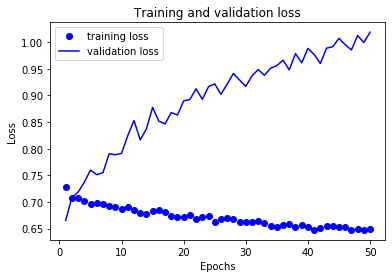

In [51]:
plt.plot(epochs, average_loss_history_RS, 'bo', label='training loss')
plt.plot(epochs, average_val_loss_history_RS, 'b', label='validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

##Plotting train and validation accuracy RandomSearch

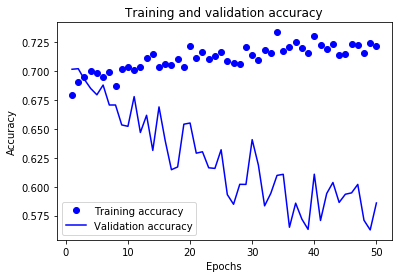

In [52]:
plt.plot(epochs, average_acc_history_RS, 'bo', label='Training accuracy')
plt.plot(epochs, average_val_acc_history_RS, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend() 